In [26]:
import sys
sys.path.append('../ATLAS_anomaly_detection/.')
sys.path.append('../ATLAS_anomaly_detection/decorrelation/.')
from utils import load_LHCO
from helpers import add_vars
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras

Using TensorFlow backend.


In [21]:
lhco = load_LHCO()
data, sim, signal = add_vars(lhco['pythia_qcd']), add_vars(lhco['herwig_qcd']), add_vars(lhco['wprime'])

## load data

the best way to do this is to specify a training and testing version of the features, signal tags, simulation vs data tags, and sb tags.

In [757]:
from sklearn.model_selection import train_test_split

n_signal = 1000
cols = ['mJJ', 'maxmass', 'minmass', 'tau21a', 'tau21b']

test_frac = 0.5

x_data,x_data_test,x_sim,x_sim_test = train_test_split(data.loc[:,cols].values, sim.loc[:,cols].values, test_size=test_frac) 

signal_idx = np.random.choice(len(signal), n_signal, replace=False)

x = np.concatenate([x_data, x_sim, signal.loc[:,cols].iloc[signal_idx].values])
x[:,:3]/=1000
y_signal = np.concatenate([np.zeros(len(x_data)), np.zeros(len(x_sim)), np.ones(len(signal_idx))])
y_sim = np.concatenate([np.ones(len(x_data)), np.zeros(len(x_sim)), np.ones(len(signal_idx))])
y_sr = ((x[:,0] <= 3.7) & (x[:,0] >= 3.3))
y_sb = ((x[:,0] > 3.0) & (x[:,0] < 3.3)) | ((x[:,0] > 3.7) & (x[:,0] < 4.0))

x_test = np.concatenate([x_data_test, x_sim_test, np.delete(signal.loc[:,cols].values, signal_idx, axis=0)])
x_test[:,:3]/=1000
y_sr_test = ((x_test[:,0] <= 3.7) & (x_test[:,0] >= 3.3))
y_sb_test = ((x_test[:,0] > 3.0) & (x_test[:,0] < 3.3)) | ((x_test[:,0] > 3.7) & (x_test[:,0] < 4.0))
y_signal_test = np.concatenate([np.zeros(len(x_data_test)), np.zeros(len(x_sim_test)), np.ones(len(signal) - len(signal_idx))])
y_sim_test = np.concatenate([np.ones(len(x_data_test)), np.zeros(len(x_sim_test)), np.ones(len(signal) - len(signal_idx))])

print(((y_signal==1)&(y_sim==1)&(y_sr==1)).sum()/np.sqrt(((y_signal==0)&(y_sim==1)&(y_sr==1)).sum()))

3.0637613774740213


### create architectures

In [703]:
sb_model = keras.models.Sequential()
sb_model.add(keras.layers.Dense(64, input_shape=(5,), activation='relu'))
sb_model.add(keras.layers.Dense(64, activation='relu'))
sb_model.add(keras.layers.Dense(64, activation='relu'))
sb_model.add(keras.layers.Dense(1, activation='sigmoid'))

base_model = keras.models.Sequential()
base_model.add(keras.layers.Dense(64, input_shape=(4,), activation='relu'))
base_model.add(keras.layers.Dense(64, activation='relu'))
base_model.add(keras.layers.Dense(64, activation='relu'))
base_model.add(keras.layers.Dense(1, activation='sigmoid'))

# set architectures
dctr_model_arch = sb_model.to_json()
base_model_arch = base_model.to_json()

In [771]:
%run models.py

global_params = {
    
}

models = {
    'dvsim': data_vs_sim(model=base_model_arch, verbose=1, epochs=1),
    'salad': SALAD(model=base_model_arch, sb_model=dctr_model_arch, verbose=1, epochs=3, sb_epochs=3),
    'cwola': cwola(model=base_model_arch, verbose=1, epochs=3)
}

for name,m in models.items():
    m.fit(x[:,1:][y_sr | y_sb], y_sim=y_sim[y_sr | y_sb], y_sr=y_sr[y_sr | y_sb], m=x[:,0][y_sr | y_sb])

Train on 85649 samples, validate on 36707 samples
Epoch 1/3
85649/85649 [==============================] - 15s 180us/step - loss: 0.6109 - val_loss: 1.1653
Epoch 2/3
85649/85649 [==============================] - 1s 8us/step - loss: 0.5993 - val_loss: 1.1791
Epoch 3/3
85649/85649 [==============================] - 1s 8us/step - loss: 0.5982 - val_loss: 1.2770
Train on 141634 samples, validate on 60701 samples
Epoch 1/3
141634/141634 [==============================] - 16s 113us/step - loss: 0.5976 - val_loss: 1.2141
Epoch 2/3
141634/141634 [==============================] - 1s 8us/step - loss: 0.5928 - val_loss: 1.2224
Epoch 3/3
141634/141634 [==============================] - 1s 8us/step - loss: 0.5923 - val_loss: 1.2176
Train on 85649 samples, validate on 36707 samples
Epoch 1/3
85649/85649 [==============================] - 16s 187us/step - loss: 0.6931 - val_loss: 0.7153
Epoch 2/3
85649/85649 [==============================] - 1s 8us/step - loss: 0.6928 - val_loss: 0.6935
Epoch 3/3


In [799]:
%run models.py
s = cwola(model=m.model)

s.get_params(copy_models=True)

{'batch_size': 1000,
 'callbacks': [],
 'compile': True,
 'epochs': 10,
 'loss': 'binary_crossentropy',
 'metrics': [],
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f202a6fe828>,
 'optimizer': 'adam',
 'test_size': 0.3,
 'verbose': False}

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


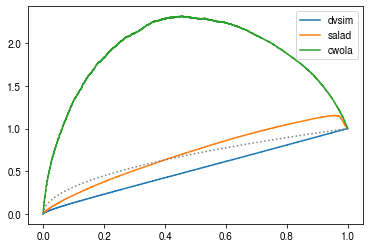

In [778]:
from sklearn.metrics import roc_curve

for name,m in models.items():
    yhat = m.predict(x_test[y_sr_test,1:])
    fpr,tpr,thresh = roc_curve(y_signal_test[y_sr_test], yhat)
    plt.plot(tpr, tpr/np.sqrt(fpr), label=name)
plt.plot(tpr, tpr/np.sqrt(tpr), ls=':', color='tab:grey')
plt.legend()
plt.show()

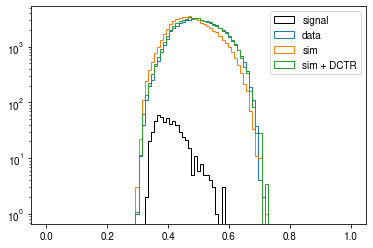

In [675]:
def plot_set(x, y, w):
    for i in range(x.shape[1]):
        plt.figure()
        _,bins,_ = plt.hist(x[y==1,i], histtype='step', bins=100, weights=None, label='data')
        plt.hist(x[y==0,i], histtype='step', bins=bins, weights=None, label='sim')
        plt.hist(x[y==0,i], histtype='step', bins=bins, weights=w[y==0], label='sim + DCTR')
        plt.legend()f
        plt.show()
        
yhat = np.squeeze(dvsim.predict(x_train[sr]))
w_sr = s.predict_weight(x_train[sr])

plt.hist(yhat[(y_train[sr] == 1) & (y_true_train[sr] == 1)], histtype='step', bins=np.linspace(0,1,100), label='signal', color='black')
plt.hist(yhat[(y_train[sr] == 1) & (y_true_train[sr] == 0)], histtype='step', bins=np.linspace(0,1,100), label='data')
plt.hist(yhat[y_train[sr] == 0], histtype='step', bins=np.linspace(0,1,100), label='sim')
plt.hist(yhat[y_train[sr] == 0], histtype='step', weights=w_sr[y_train[sr] == 0], bins=np.linspace(0,1,100), label='sim + DCTR')
plt.legend()
plt.yscale('log')
plt.show()

In [575]:
yhat_test_sr = s.predict(x_test[(x_test[:,0] < 3.7) & (x_test[:,0] > 3.3)])
y_true_test_sr = y_true_test[(x_test[:,0] < 3.7) & (x_test[:,0] > 3.3)]


In [658]:
%run models.py

In [659]:
dvsim = data_vs_sim(model=dvsim.model)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


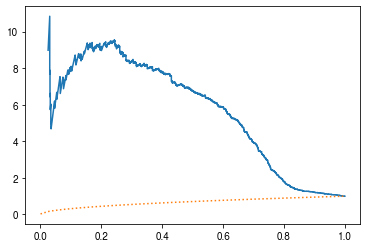

In [576]:
from sklearn.metrics import roc_curve

fpr,tpr,thresh = roc_curve(y_true_test_sr, yhat_test_sr)
plt.plot(tpr, tpr/np.sqrt(fpr))
plt.plot(tpr, tpr/np.sqrt(tpr), ls=':')

In [602]:
window = (x_test[:,0] < 4.5) & (x_test[:,0] > 2.5)
dtag = y_test[window] == 1
stag = y_test[window] == 0


In [660]:
%timeit dvsim.predict(x_test[window])

247 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [662]:
snew = SALAD()

In [666]:
pms = s.get_params()
del pms['path']

In [668]:
snew.sr_model

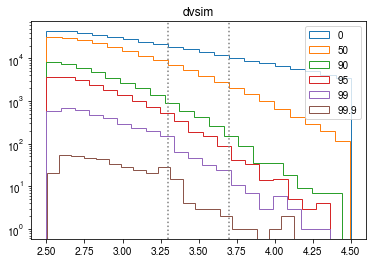

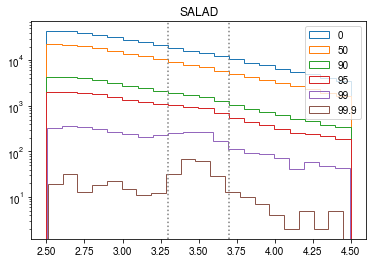

In [669]:

pvals = [0, 50, 90, 95, 99, 99.9]

for model_name,m in {'dvsim': dvsim, 'SALAD': s}.items():
    yhat_all = m.predict(x_test[window])

    for p in pvals:
        pct = np.percentile(yhat_all[dtag], p)
        tag = yhat_all[dtag] >= pct

        plt.hist(x_test[window,0][dtag][tag], histtype='step', label=p, density=0, bins=20)

    plt.gca().axvline(3.3, color='tab:grey', ls=':')
    plt.gca().axvline(3.7, color='tab:grey', ls=':')

    plt.title('{}'.format(model_name))
    plt.legend()
    plt.yscale('log')
    plt.show()

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in subtract


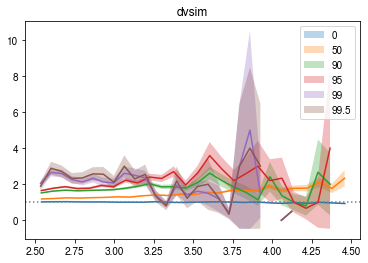

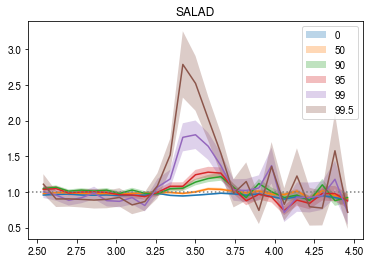

In [677]:
pvals = [0, 50, 90, 95, 99, 99.5]

for model_name,m in {'dvsim': dvsim, 'SALAD': s}.items():
    yhat_all = m.predict(x_test[window])
    if hasattr(m, 'predict_weight'):
        w = m.predict_weight(x_test[window])
    else:
        w = np.ones_like(y_test[window])
        
    for p in pvals:
        pct = np.percentile(yhat_all[dtag], p)
        tag = yhat_all[dtag] >= pct
        tag_s = yhat_all[stag] >= pct

        dcnts,bns = np.histogram(x_test[window,0][dtag][tag], bins=25,)
        scnts,bns = np.histogram(x_test[window,0][stag][tag_s], weights=w[stag][tag_s], bins=25,)
        xpt = bns[:-1] + np.diff(bns)*.5

        val = (dcnts/scnts)
        err = val*np.sqrt(1/dcnts + 1/scnts)

        plt.plot(xpt, val)
        plt.fill_between(xpt, val - err, val + err, alpha=.3, label=p)

    plt.legend()
    plt.axhline(1, color='tab:grey', ls=':')
    plt.title(model_name)
    plt.show()

In [ ]:
w_sb = s.predict_weight(x_tr[sb])
plot_set(x_tr[sb], y_tr[sb], w_sb)

In [ ]:
w_sr = s.predict_weight(x_tr[sr])
plot_set(x_tr[sr], y_tr[sr], w_sr)

In [685]:
%run models.py